# The House Price Prediction
## Team 4: Vicky Van Der Wagt, Halee Staggs, Bethany Wang

More thoughts for Discussion

* Make loc_cat two dimentional categories, may use 9 categories if not 15 for modeling
* Standardize/normalize data before modeling
* In the modeling step, do some experiments with more variables and different combinations of variables to achieve the best model
** Candidate variables for modeling: sqft_living, loc_cat, bedrooms, bathrooms, floors, grade

Changes 12/6/22 By: Bethany
* Reorganize and clean up the code before the modeling section
* Modify the way to handle missing data and outliers
* Validate the steps for data cleaning
* Added interpretations

Changes 11/19/22
    
*  Inserted data cleaning setps
* Although earlier we talked about replacing missing values with item that correlates to it the most, after looking at graphs, they do not have clear linear relationships. Therefore, I used the averages for now. Will read more projects to see what else they did. 
* Also added discretization (5 categories for longitude, 3 categories for latitude). Then added a loc_cat column (location category) which has the concatenated values. Clear relationship between loc_cat and price
* For duplicate ids, removed the oldest entry and only kept the most recent one. 
* Removed outliers using quartiles in iqr for sqft_living and sqft_lot since those had the most extreme values. Also concluded the 33 bedroom entry was a mistake, as the square footage was less than 2000(definitely could not fit 33 bedrooms). Therefore, replaced it same method as other bedrooms (with average bedrooms). 
* Holding off on deleting most columns until we decide what is relevant to our models


Changes 11/24/22
1. Remove outliers from price. 

2. Updated "yr_renovated" to Yes/No. Only ~900 with yes. 

3. Converted year built to age. Added column.

4. Normalized outcome variable with square root transformation instead of log. Original data was positively skewed, and then log transformed was negatively skewed so log was not the right method.  

5. Reduced dimensions for lat/long location groups. Added a 3X3 grid to compare. There were 3 long/lat groups that only ontained 1 house. By reducing dimensions, it grouped everything so each area is better represented. When looking at the bar chart, there are 4 distinct price levels. I think we can reduce the location dimensions even further into 3 groups (North, Central, South). The prices differences go North-South more so than East-West. This will help with final model to reduce number of dummy variables.

6. Updated numerical/categorical/ordinal lists of variables. 

7. **Most of our variables are discrete. We cannot compute mean and standard deviation for them. Udated missing values to fill with median. Use PMF for distributions. Median house prices for Washington state listed here: https://ofm.wa.gov/washington-data-research/statewide-data/washington-trends/economic-trends/median-home-price. 2014 = 267,600 and 2015 = 289,100. Maybe we can use this as some sort of cut-off. Add binary variable of above median or below median?? Combine with location?? ** 

8. Ordinal variables can be used in correlations. Added them to the numerical correlation matrix. However, ordinal data is not 100% valid to use in linear regression. Grade is correlated with price, but not rating. 

9. We cannot use price/sqft for a predictor variable. This would mean that we are using a dimension of our dependent variable inside our model, which is invalid. Just stick to continuous measurement of sqft living separate from price. Commented out this section and updated price vs. price/log histogram display.  

10. Tested Spearman rank correlation between ordinal variables (grade and rating). No relationship found. 

11. Added Chi-Square tests for categorical variables to test relationship with price, location, and other categories. Used log-normal price data for test. Turned "price" into categorical with 6 bins to test relationships. 6 bins = 3 SD on each side, so basically 100% of data. The year 2014 contains months from only May-Dec, and 2015 contains months from January to May. This means we cannot use "year" for any meaningful comparison. Together they create a full year of data. Confirmed with x2 test. Also tested month on its own. Month shows a difference in x2 test. Formal test of Vicky's percentage differences.  

12. Normalized sqft_living before modeling with square root transformation.

13. Testing relationship between all predictor variables with x2 conversion. 

14. Final proposed predictor variables: sqft_living - log, location, yr_sold.

15. Ran multinomial linear regression. price_log ~ sqft_log + locations(dummy) + yr_sold + e

16. Added data visualizations.

17. Added conclusion. 

Changes 11/27/22

1. Added 'season' column derived from the month column. (Under Feature Construction and Discretization)

## 1. Introduction

## 2. Data Importing and Cleaning

* Import dataset and describe characteristics such as dimensions, data types, file types, and import methods used
* Clean, wrangle, and handle missing data
* Transform data appropriately using techniques such as aggregation, normalization, and feature construction
* Reduce redundant data and perform need-based discretization

In [398]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as stats
from scipy.stats import spearmanr
import statsmodels.api as sm

In [399]:
# To ignore the warning message
warnings.filterwarnings('ignore')

### Import data

In [400]:
dataset = pd.read_csv(r'house_sales.csv')
dataset.shape

(21613, 21)

### Check data characteristics

In [401]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       20479 non-null  float64
 4   bathrooms      20545 non-null  float64
 5   sqft_living    20503 non-null  float64
 6   sqft_lot       20569 non-null  float64
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [402]:
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3.0,1.00,1180.0,5650.0,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3.0,2.25,2570.0,7242.0,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2.0,1.00,770.0,10000.0,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4.0,3.00,1960.0,5000.0,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3.0,2.00,1680.0,8080.0,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### Check missing data

In [403]:
dataset.isnull().sum()

id                  0
date                0
price               0
bedrooms         1134
bathrooms        1068
sqft_living      1110
sqft_lot         1044
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated        0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

We detect missigng data in four columns: bedrooms, bathrooms, sqft_living, sqft_lot. Here are the strategies to handle the missing data:
* Fill the missing values in sqft_living: sqft_living = sqft_above +sqft_basement
* Check and remove outliers from sqft_living column: remove 1.5IQR above
* Check distribution of sqft_living and divide it into different groups by size range: 0-999, 1000-1999, ...
* Fill sqft_lot with the mean of the the corresponding size range group
* Fill bedrooms with the median of the the corresponding size range group
* Fill bathrooms with the median of the the corresponding size range group

### Handle Missing Data

#### * Fill the missing values in sqft_living: sqft_living = sqft_above +sqft_basement

In [404]:
sqft_above_col = dataset['sqft_above']
sqft_basement_col = dataset['sqft_basement']
dataset['sqft_living'].fillna(sqft_above_col + sqft_basement_col, inplace = True)

#### * Remove outliers from sqft_living column: use 7000 as the upperlimit accoriding to the scatter plot

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

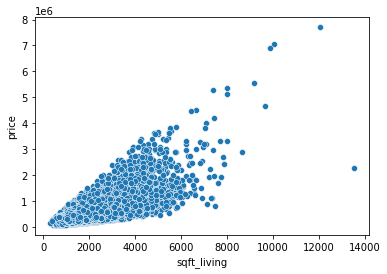

In [405]:
# Use scatter plot to check distribution of sqft_living
sns.scatterplot(data=dataset, x="sqft_living", y="price")

In [406]:
# Calculate IQR
q1 = dataset['sqft_living'].quantile(.25)
q3 = dataset['sqft_living'].quantile(.75)
iqr = q3 - q1
upperlimit = q3 + (1.5 * iqr)
upperlimit_count = len(dataset[dataset.sqft_living > upperlimit])
print(f"Upper limit by 1.5IQR = {upperlimit}, count = {upperlimit_count}")

Upper limit by 1.5IQR = 4234.5, count = 572


We use 7000 as the upperlimit to define outliers instead of using 1.5IQR

In [407]:
upperlimit1 = 7000
dropped_count = len(dataset[dataset.sqft_living > upperlimit1])
dropped_percent = dropped_count / len(dataset)
print(f"{dropped_count} rows ({round(100 * dropped_percent, 3)} percent of data) have been dropped.")

dataset = dataset[dataset['sqft_living'] < upperlimit1]

dataset['sqft_sqrt'] = np.sqrt(dataset['sqft_living'])
dataset.shape

28 rows (0.13 percent of data) have been dropped.


(21584, 22)

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

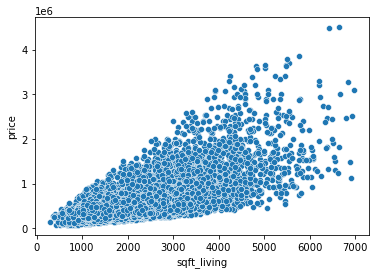

In [408]:
# Recheck sqft_living distribution
sns.scatterplot(data=dataset, x="sqft_living", y="price")

#### * Check sqft_lot distribution

<AxesSubplot:xlabel='sqft_lot', ylabel='price'>

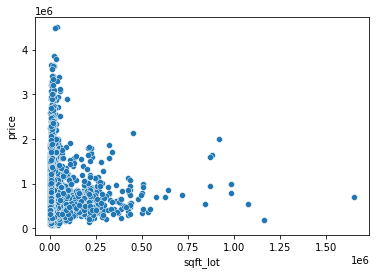

In [409]:
sns.scatterplot(data=dataset, x="sqft_lot", y="price")

#### * Remove outliers from sqft_lot column: use 500000 as the upperlimit accoriding to the scatter plot

In [410]:
#removed outliers with large sqft_lots
q1 = dataset['sqft_lot'].quantile(.25)
q3 = dataset['sqft_lot'].quantile(.75)
iqr = q3 - q1
upperlimit = q3 + (1.5*iqr)
upperlimit_count = len(dataset[dataset.sqft_lot > upperlimit])
print(f"Upper limit by 1.5IQR = {upperlimit}, count = {upperlimit_count}")

Upper limit by 1.5IQR = 19098.125, count = 2310


In [411]:
# dataset = dataset[dataset['sqft_living']<upperlimit]
upperlimit_set = 500000
upperlimit_set_count = len(dataset[dataset.sqft_lot > upperlimit_set])
print(f"Upper limit_set={upperlimit_set}, count = {upperlimit_set_count}")
dropped_count = len(dataset[dataset.sqft_lot > upperlimit_set])
dropped_percent = dropped_count / len(dataset)
print(f"{dropped_count} rows ({round(100 * dropped_percent, 3)} percent of data) have been dropped.")

dataset.drop(dataset[dataset.sqft_lot > upperlimit_set].index, inplace=True)


Upper limit_set=500000, count = 20
20 rows (0.093 percent of data) have been dropped.


<AxesSubplot:xlabel='sqft_lot', ylabel='price'>

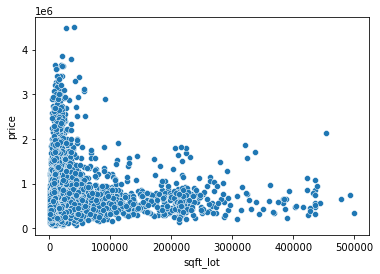

In [412]:
sns.scatterplot(data=dataset, x="sqft_lot", y="price")

#### * Add a column  indicating the sqft_living range: 0 (0-999), 1000 (1000-1999), 2000(2000-2999) ... 6000(6000-6999)

In [413]:
dataset['sqft_living_range'] = (dataset['sqft_living']//1000) * 1000


####  * Impute missing data in bathrooms, bedrooms, sqft_lot with the mean/median by sqft_living_range


In [414]:
# Get unique range list
ranges = dataset['sqft_living_range'].unique()
imputed_dfs = []

for size_range in ranges:
    range_df = dataset[dataset['sqft_living_range'] == size_range]
    range_df['bathrooms'].fillna(range_df['bathrooms'].median(), inplace = True)
    range_df['bedrooms'].fillna(range_df['bedrooms'].median(), inplace = True)
    range_df['sqft_lot'].fillna(range_df['sqft_lot'].mean(), inplace = True)
      
    imputed_dfs.append(range_df)

#Combine all the region subset back into a new dataframe
dataset = pd.concat(imputed_dfs, axis=0)
dataset.isnull().sum()                                                  

id                   0
date                 0
price                0
bedrooms             0
bathrooms            0
sqft_living          0
sqft_lot             0
floors               0
waterfront           0
view                 0
condition            0
grade                0
sqft_above           0
sqft_basement        0
yr_built             0
yr_renovated         0
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
sqft_sqrt            0
sqft_living_range    0
dtype: int64

### Clean up data

#### * Remove outliers from bedrooms  columns

<AxesSubplot:title={'center':'Boxplots'}, xlabel='Bedrooms', ylabel='Counts'>

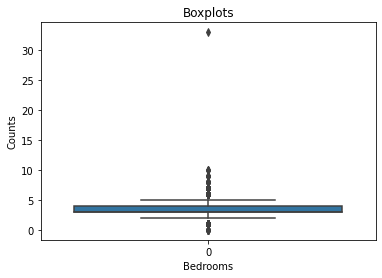

In [415]:
# Use boxplot to check outliers
plt.figure()
plt.title('Boxplots')
plt.xlabel('Bedrooms')
plt.ylabel('Counts')
sns.boxplot(data = dataset['bedrooms'])

From the box plot, any house with more than 6 bedrooms or 0 bedrooms can be counted as an outlier

In [416]:
# Check outliers' count
bedroom_drop_count = len(dataset[(dataset['bedrooms'] > 6) | (dataset['bedrooms'] == 0)])
bedroom_drop_count_percent = round(100 * bedroom_drop_count/data_count, 2)
data_count = len(dataset)
print(f"bedroom_drop_count= {bedroom_drop_count},  Percent={bedroom_drop_count_percent}%")

bedroom_drop_count= 64,  Percent=0.3%


In [417]:
# Drop outliers
dataset = dataset[(dataset['bedrooms'] <= 6) & (dataset['bedrooms'] > 0)]

#### * Remove outliers from bathrooms column

<AxesSubplot:title={'center':'Boxplots'}, xlabel='Bathrooms', ylabel='Counts'>

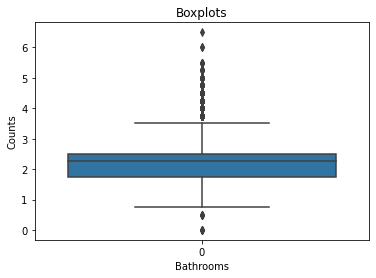

In [418]:
plt.figure()
plt.title('Boxplots')
plt.xlabel('Bathrooms')
plt.ylabel('Counts')
sns.boxplot(data = dataset['bathrooms'])

From the box plot, any house with more than 4 bathrooms or less than 1 bathrooms can be counted as an outlier

In [419]:
# Check outlier counts
bathroom_drop_count = len(dataset[(dataset['bathrooms'] >4) | (dataset['bathrooms'] < 1)])
bathroom_drop_count_percent = round(100 * bathroom_drop_count/data_count, 2)
print(f"bathroom_drop_count= {bathroom_drop_count},  Percent= {bathroom_drop_count_percent}%")


bathroom_drop_count= 294,  Percent= 1.36%


In [420]:
#Drop outliers
dataset = dataset[ (dataset['bathrooms'] <= 4) & (dataset['bathrooms'] >= 1) ]

dataset.shape

(21206, 23)

#### * Remove outliers from price column

In [421]:
#removed outliers in price
q1 = dataset['price'].quantile(.25)
q3 = dataset['price'].quantile(.75)
iqr = q3 - q1

#tested with 1.5
upperlimit = q3 + (1.5*iqr)
lowerlimit = q1 - (1.5*iqr)

upperlimit_count = len(dataset[dataset.price > upperlimit])
print(f"Upper limit by 1.5IQR = {upperlimit}, count = {upperlimit_count}")

Upper limit by 1.5IQR = 1107500.0, count = 1006


In [422]:
dataset = dataset[dataset['price']<upperlimit]

#### * Drop duplicate id

In [423]:
#dropping the earliest entry of each duplicate ID 
dataset.sort_values(by=['id', 'date'], inplace=True)
#keeping the entry with the most recent date
dataset = dataset.drop_duplicates(subset=['id'], keep='last')
dataset.shape


(20032, 23)

* Drop redundant data columns: 

In [424]:
dataset.drop(['sqft_above', 'sqft_basement'], axis=1, inplace = True)

### Feature Transformation

#### * Add columns for year sold, month sold, and season

In [425]:
from datetime import datetime
dataset['date'] = pd.to_datetime(dataset['date'], format='%Y/%m/%d')

In [426]:
dataset['yr_sold'] = pd.DatetimeIndex(dataset['date']).year
dataset['month_sold'] = pd.DatetimeIndex(dataset['date']).month


dataset['month_sold'] = dataset['month_sold'].astype(str)
look_up = {'1': 'Winter', '2': 'Winter', '3': 'Spring', '4': 'Spring', '5': 'Spring', 
           '6': 'Summer', '7': 'Summer', '8': 'Summer', '9': 'Fall', '10': 'Fall', '11': 'Fall', '12': 'Winter'}

dataset['season'] = dataset['month_sold'].apply(lambda x: look_up[x])
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_sqrt,sqft_living_range,yr_sold,month_sold,season
2497,1000102,2015-04-22,300000.0,6.0,3.00,2400.0,9373.0,2.0,0,0,...,98002,47.3262,-122.214,2060,7316,48.989795,2000.0,2015,4,Spring
6735,1200019,2014-05-08,647500.0,4.0,1.75,2060.0,26036.0,1.0,0,0,...,98166,47.4444,-122.351,2590,21891,45.387223,2000.0,2014,5,Spring
8411,1200021,2014-08-11,400000.0,3.0,1.00,1460.0,43000.0,1.0,0,0,...,98166,47.4434,-122.347,2250,20023,38.209946,1000.0,2014,8,Summer
8809,2800031,2015-04-01,235000.0,3.0,1.00,1430.0,7599.0,1.5,0,0,...,98168,47.4783,-122.265,1290,10320,37.815341,1000.0,2015,4,Spring
3557,3600057,2015-03-19,402500.0,4.0,1.75,1650.0,3504.0,1.0,0,0,...,98144,47.5803,-122.294,1480,3504,40.620192,1000.0,2015,3,Spring


#### * Add column to change year renovated to binary variable

In [427]:
#update dataset to Yes/No for renovated
dataset["renovate"] = pd.cut(dataset["yr_renovated"],2,labels = ['0','1'])
dataset["renovate"] = pd.to_numeric(dataset['renovate'])

#### * Add new column house_age = yr_sold - yr_built

In [428]:
t1 = dataset['yr_sold']
t2 = dataset['yr_built']
house_age = t1 - t2
dataset['house_age'] = house_age
dataset[['yr_sold', 'yr_built', 'house_age']].head()

,yr_sold,yr_built,house_age
2497,2015,1991,24
6735,2014,1947,67
8411,2014,1952,62
8809,2015,1930,85
3557,2015,1951,64


#### * Generate Categories for lat, long, and latitude + longitude

[Text(0, 0, 'south-midwest'),
 Text(1, 0, 'central-west'),
 Text(2, 0, 'central-midwest'),
 Text(3, 0, 'north-west'),
 Text(4, 0, 'north-midwest'),
 Text(5, 0, 'south-west'),
 Text(6, 0, 'north-central'),
 Text(7, 0, 'south-central'),
 Text(8, 0, 'central-central'),
 Text(9, 0, 'central-east'),
 Text(10, 0, 'central-mideast'),
 Text(11, 0, 'north-east'),
 Text(12, 0, 'north-mideast'),
 Text(13, 0, 'south-mideast')]

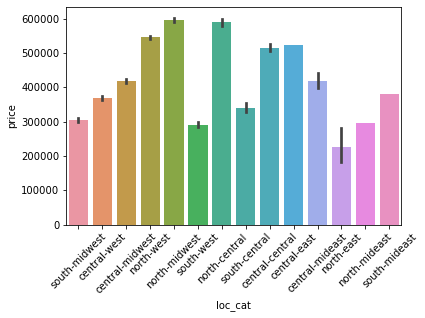

In [429]:
# Add column 'lat_cat' to represent the lattitude in three categories
dataset['lat_cat'] = pd.cut(dataset['lat'],3,labels = ['south', 'central', 'north'])
dataset.head()

# Add column 'long_cat' to represent the longitude in five categories
dataset['long_cat'] = pd.cut(dataset['long'],5,labels = ['west', 'midwest', 'central', 'mideast', 'east'])
dataset.head()

lat_cat = dataset['lat_cat']
long_cat = dataset['long_cat']

#aggregate the latitude and longitude together for a final location category
dataset['loc_cat'] = dataset[['lat_cat', 'long_cat']].agg('-'.join, axis=1)

location_category = dataset['loc_cat']
price = dataset['price']

#plot just to see
location_barplot = sns.barplot(x=location_category, y=price)
#makes it so the labels don't run into each other
location_barplot.set_xticklabels(location_barplot.get_xticklabels(), rotation = 45, horizontalalignment = 'center')

[Text(0, 0, 'south-west'),
 Text(1, 0, 'central-west'),
 Text(2, 0, 'north-west'),
 Text(3, 0, 'north-central'),
 Text(4, 0, 'central-central'),
 Text(5, 0, 'south-central'),
 Text(6, 0, 'central-east'),
 Text(7, 0, 'north-east'),
 Text(8, 0, 'south-east')]

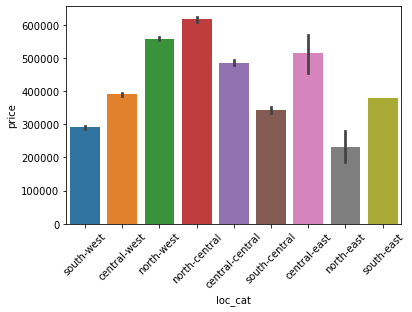

In [430]:
# Add column 'lat_cat' to represent the lattitude in three categories
dataset['lat_cat'] = pd.cut(dataset['lat'],3,labels = ['south', 'central', 'north'])
dataset.head()

# Add column 'long_cat' to represent the longitude in five categories
dataset['long_cat'] = pd.cut(dataset['long'],3,labels = ['west', 'central', 'east'])
dataset.head()

lat_cat = dataset['lat_cat']
long_cat = dataset['long_cat']

#aggregate the latitude and longitude together for a final location category
dataset['loc_cat'] = dataset[['lat_cat', 'long_cat']].agg('-'.join, axis=1)

location_category = dataset['loc_cat']
price = dataset['price']
#plot just to see
location_barplot = sns.barplot(x=location_category, y=price)
#makes it so the labels don't run into each other
location_barplot.set_xticklabels(location_barplot.get_xticklabels(), rotation = 45, horizontalalignment = 'center')

## 3. Exploratory Data Analysis and Visualization

* Identify categorical, ordinal, and numerical variables within the data
* Provide measures of centrality and distribution with visualizations
* Diagnose for correlations between variables and determine independent and dependent variables
* Perform exploratory analysis in combination with visualization techniques to discover patterns and features of interest

### Classify features

#### * Classify variables as categorical, ordinal, continues and discrete variables within the prepared dataset

In [431]:
# Identify categorical, ordinal, continues and discrete variables within the prepared data
cont_vars = ['price', 'sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'house_age']
discrete_vars = ['bedrooms', 'bathrooms', 'floors', 'yr_sold', 'month_sold']
ordinal_vars = ['condition', 'grade']
cat_vars = ['waterfront', 'view', 'zipcode', 'loc_cat', 'season']

### Statistical Analysis

#### * Get statistics on the continous numerical variables, house_age is discrete, but can be used as continuous type

In [432]:
cont_subset = dataset[cont_vars]

In [433]:
# Find the statistics for the numerical variables
round(cont_subset.describe(), 2)

,price,sqft_living,sqft_lot,sqft_living15,sqft_lot15,house_age
count,20032.00,20032.00,20032.00,20032.00,20032.00,20032.00
mean,476225.99,1967.67,13931.50,1920.46,12239.65,43.37
std,205150.50,754.83,31014.82,609.84,25222.11,29.14
min,78000.00,390.00,520.00,399.00,651.00,-1.00
25%,316000.00,1400.00,5080.00,1470.00,5040.00,18.00
50%,438000.00,1850.00,7700.00,1800.00,7526.00,40.00
75%,600000.00,2420.00,10480.00,2280.00,9840.00,63.00
max,1107460.00,6050.00,499571.00,4950.00,560617.00,115.00


### Correlation Analysis

In [434]:
# Find correlation coefficients between variables
corr_check_cols = cont_vars + discrete_vars + ordinal_vars

corr_check_subset = dataset[corr_check_cols]
round(corr_check_subset.corr(), 2)

,price,sqft_living,sqft_lot,sqft_living15,sqft_lot15,house_age,bedrooms,bathrooms,floors,yr_sold,condition,grade
price,1.00,0.61,0.10,0.56,0.08,-0.05,0.30,0.45,0.27,-0.00,0.04,0.62
sqft_living,0.61,1.00,0.19,0.74,0.17,-0.35,0.61,0.71,0.33,-0.04,-0.07,0.70
sqft_lot,0.10,0.19,1.00,0.17,0.77,-0.06,0.04,0.08,-0.02,-0.01,-0.01,0.11
sqft_living15,0.56,0.74,0.17,1.00,0.18,-0.36,0.40,0.53,0.26,-0.03,-0.12,0.67
sqft_lot15,0.08,0.17,0.77,0.18,1.00,-0.06,0.03,0.07,-0.03,-0.01,-0.00,0.10
house_age,-0.05,-0.35,-0.06,-0.36,-0.06,1.00,-0.18,-0.55,-0.51,0.02,0.36,-0.49
bedrooms,0.30,0.61,0.04,0.40,0.03,-0.18,1.00,0.50,0.16,-0.01,0.02,0.34
bathrooms,0.45,0.71,0.08,0.53,0.07,-0.55,0.50,1.00,0.50,-0.03,-0.14,0.61
floors,0.27,0.33,-0.02,0.26,-0.03,-0.51,0.16,0.50,1.00,-0.02,-0.28,0.45
yr_sold,-0.00,-0.04,-0.01,-0.03,-0.01,0.02,-0.01,-0.03,-0.02,1.00,-0.05,-0.04


<AxesSubplot:title={'center':'Heat Map of Correlation Coefficients'}>

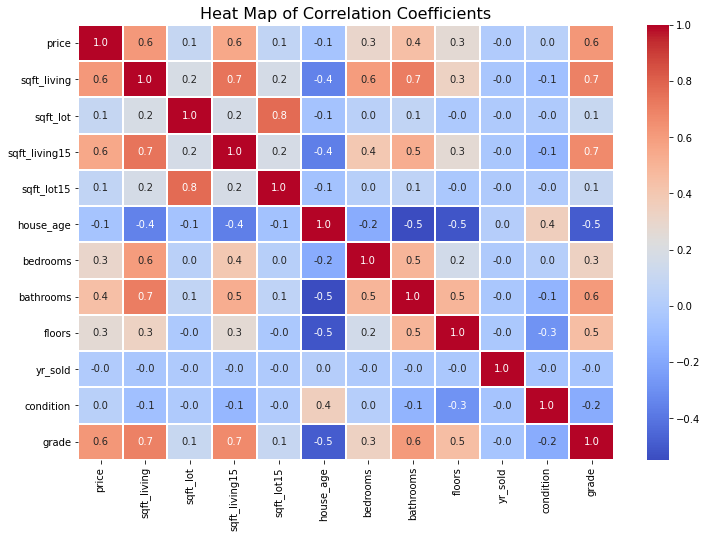

In [435]:
# Heatmap for correlations from original data
plt.figure(figsize=(12, 8))
plt.title("Heat Map of Correlation Coefficients", fontsize=16)
sns.heatmap(corr_check_subset.corr(), cmap = 'coolwarm', fmt = '.1f', linewidths = 1, annot = True)

From the heatmap, we see:
* Almost no correlation between dependent variable 'price' and independent variables: sqft_lot, house_age, condition, yr_sold, sft_lot15, therefore these variables will not be selected for modeling
* There are strong correlation between sqft_living and sqft_living15, between sqft_lot and sqft_lot15, therefore, we conclude that sqft_living15 and sqft_lot15 are redundant and should not be used in modeling

### Scatter Plots for Numerical Variables vs. Price

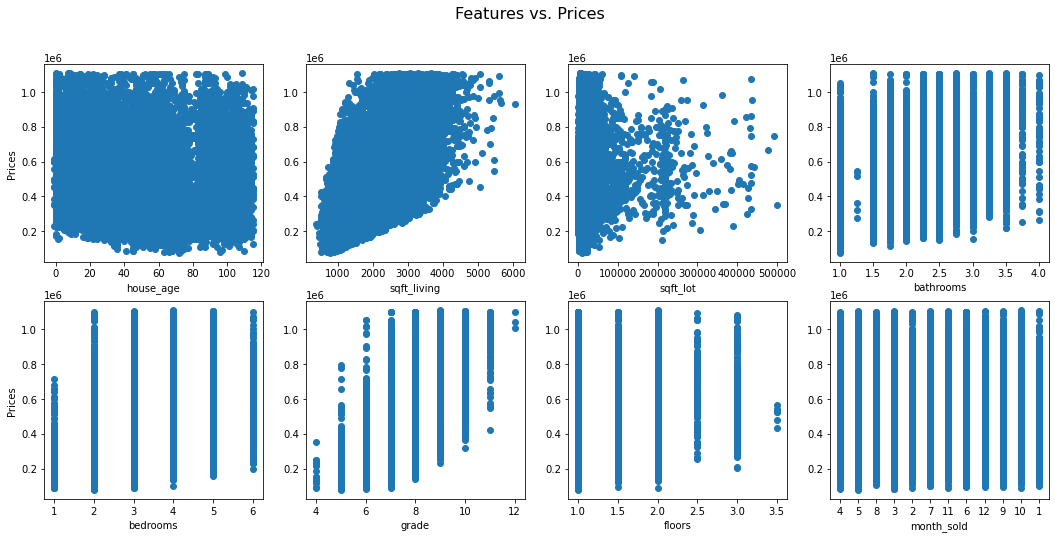

In [436]:
scatter_cols = ['house_age', 'sqft_living', 'sqft_lot', 'bathrooms', 'bedrooms', 'grade', 'floors', 'month_sold']
pair_cols = ['sqft_living', 'sqft_lot', 'grade', 'condition']

#Create scatter plots
fig,axes = plt.subplots(nrows=2,ncols=4,figsize=(18,8))
fig.suptitle("Features vs. Prices",fontsize=16)

#for n in range(len(scatter_cols)):
for n in (0,1,2,3,4,5,6,7):   
    i = 0 if n < 4 else 1  
    j = n % 4;
    axes[i][j].scatter(dataset[scatter_cols[n]], dataset['price'])
    axes[i][j].set_xlabel(scatter_cols[n])
    
axes[0][0].set_ylabel("Prices")
axes[1][0].set_ylabel("Prices")

plt.show()

Both the heatmap and the scatter plots confirm that:

* There are strong correlation between dependent variable 'price' and independent variables: sqft_living, bathrooms, and grade, therefore these variables will be kept for modeling
* There are week correlation between dependent variable 'price' and independent variables: bedrooms and floors. These variables will be kept for modeling

### Histogram Distribution for price and sqft_living

In [437]:
# Separate Prices into a new variable
prices = dataset['price']

<AxesSubplot:title={'center':'Distribution of Sqft_Living'}, xlabel='sqft_living'>

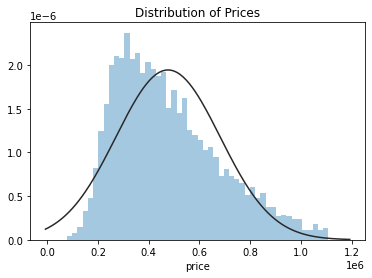

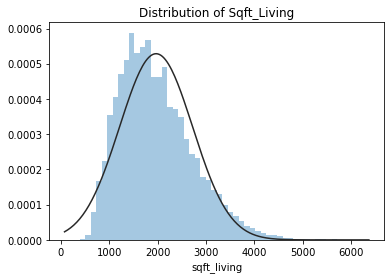

In [438]:
# Display Histogram for Prices
plt.figure(1)
plt.title('Distribution of Prices')
sns.distplot(prices, kde=False, fit=stats.norm)

# Display Histogram for Sqft_Living
plt.figure(2)
plt.title('Distribution of Sqft_Living')
sns.distplot(dataset['sqft_living'], kde=False, fit=stats.norm)

We see skewed distribution for price and see a near normal distribution for sqft_living

### Bar Plots for Categorical and Discrete Variables

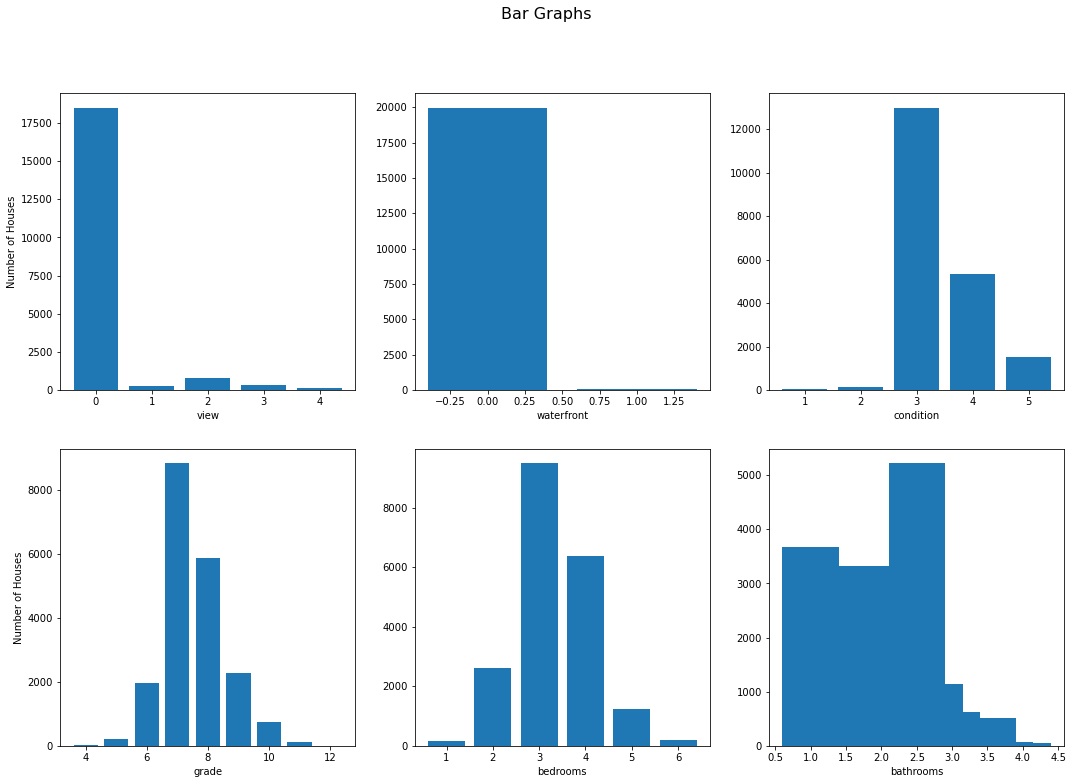

In [439]:
# Define column lists for plotting
bar_cols = ['view', 'waterfront', 'condition', 'grade', 'bedrooms', 'bathrooms']

# Create bar plots
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(18,12))
fig.suptitle("Bar Graphs",fontsize=16)

for n in (0, 1,2,3,4,5):
    i = 0 if n < 3 else 1  
    j = n % 3;
    values = dataset[bar_cols[n]].value_counts()
    pd.Series.sort_index(values, inplace=True)
    indexes = list(values.index)
    axes[i][j].bar(indexes, values)
    axes[i][j].set_xlabel(bar_cols[n])
    
axes[0][0].set_ylabel("Number of Houses")
axes[1][0].set_ylabel("Number of Houses")

plt.show()

From bar plot for view and water front, we see majority of the housed do not have view or by water front, therefore, these two features will not use considered in modeling

# Ordinal Correlation & Tests of Association (categorical)

Spearmans Rank Correlation Coefficient

In [440]:
#measure of collinearity for ordinal variables
data_ord = pd.DataFrame(dataset[ordinal_vars])

scc_1, p = spearmanr(data_ord['condition'],data_ord['grade'])
print('scc_1, p = %.3f' % scc_1)


#weak negative correlation between each other

scc_1, p = -0.189


In [441]:
dataset['price_sqrt'] = np.sqrt(dataset['price'])
#cut dataset into 6 bins for price_log
dataset['price_sqrt_cat'] = pd.cut(dataset['price_sqrt'], 6)
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_sold,month_sold,season,renovate,house_age,lat_cat,long_cat,loc_cat,price_sqrt,price_sqrt_cat
2497,1000102,2015-04-22,300000.0,6.0,3.00,2400.0,9373.0,2.0,0,0,...,2015,4,Spring,0,24,south,west,south-west,547.722558,"(536.976, 665.822]"
6735,1200019,2014-05-08,647500.0,4.0,1.75,2060.0,26036.0,1.0,0,0,...,2014,5,Spring,0,67,central,west,central-west,804.673847,"(794.668, 923.514]"
8411,1200021,2014-08-11,400000.0,3.0,1.00,1460.0,43000.0,1.0,0,0,...,2014,8,Summer,0,62,central,west,central-west,632.455532,"(536.976, 665.822]"
8809,2800031,2015-04-01,235000.0,3.0,1.00,1430.0,7599.0,1.5,0,0,...,2015,4,Spring,0,85,central,west,central-west,484.767986,"(408.131, 536.976]"
3557,3600057,2015-03-19,402500.0,4.0,1.75,1650.0,3504.0,1.0,0,0,...,2015,3,Spring,1,64,north,west,north-west,634.428877,"(536.976, 665.822]"


### Price and lattitude location.

In [442]:
#chisq_freq_1_a = pd.crosstab(dataset['price_sqrt_cat'], 
                           #dataset['loc_cat'], 
                           #margins=True, margins_name='Total')
#chisq_freq_1_a

#run test
#stats.chi2_contingency(chisq_freq_1_a)

#not valid


chisq_freq_1_b = pd.crosstab(dataset['price_sqrt_cat'], 
                           dataset['lat_cat'], 
                           margins=True, margins_name='Total')
chisq_freq_1_b

#run test
stats.chi2_contingency(chisq_freq_1_b)

#stat sig, but df and x2 are far apart


(5763.992183616798,
 0.0,
 18,
 array([[   36.82233427,   106.39901158,   137.77865415,   281.        ],
        [  462.57238419,  1336.61391773,  1730.81369808,  3530.        ],
        [  844.55496206,  2440.36167133,  3160.08336661,  6445.        ],
        [  711.94214257,  2057.17377196,  2663.88408546,  5433.        ],
        [  414.2185004 ,  1196.89421925,  1549.88728035,  3161.        ],
        [  154.88967652,   447.55740815,   579.55291534,  1182.        ],
        [ 2625.        ,  7585.        ,  9822.        , 20032.        ]]))

### Price and renovation  status.

In [443]:
#create frequency table for price bins and renovation status
chisq_freq_2 = pd.crosstab(dataset['price_sqrt_cat'].astype('category'), 
                           dataset['renovate'], 
                           margins=True, margins_name='Total')
#test chi square
chisq_freq_2
stats.chi2_contingency(chisq_freq_2)

### valid relationship between renovation and price


(141.5023066139348,
 2.97848002181164e-24,
 12,
 array([[2.70577526e+02, 1.04224740e+01, 2.81000000e+02],
        [3.39906999e+03, 1.30930012e+02, 3.53000000e+03],
        [6.20595073e+03, 2.39049271e+02, 6.44500000e+03],
        [5.23148647e+03, 2.01513528e+02, 5.43300000e+03],
        [3.04375644e+03, 1.17243560e+02, 3.16100000e+03],
        [1.13815885e+03, 4.38411542e+01, 1.18200000e+03],
        [1.92890000e+04, 7.43000000e+02, 2.00320000e+04]]))

### Price and year.

In [444]:
chisq_freq_3 = pd.crosstab(dataset['price_sqrt_cat'].astype('category'), 
                           dataset['yr_sold'].astype('category'), 
                           margins=True, margins_name='Total')
#test chi square
chisq_freq_3
stats.chi2_contingency(chisq_freq_3)

#not valid, no difference

(2.8072462635769506,
 0.9967586205120276,
 12,
 array([[  189.73672125,    91.26327875,   281.        ],
        [ 2383.52535942,  1146.47464058,  3530.        ],
        [ 4351.79063498,  2093.20936502,  6445.        ],
        [ 3668.46835064,  1764.53164936,  5433.        ],
        [ 2134.36930911,  1026.63069089,  3161.        ],
        [  798.1096246 ,   383.8903754 ,  1182.        ],
        [13526.        ,  6506.        , 20032.        ]]))

### Price and month.

In [445]:
chisq_freq_4 = pd.crosstab(dataset['price_sqrt_cat'].astype('category'), 
                           dataset['month_sold'].astype('category'), 
                           margins=True, margins_name='Total')
#test chi square
chisq_freq_4
stats.chi2_contingency(chisq_freq_4)


#valid relationship between price and month

(108.34381410018216,
 0.0036326596522396836,
 72,
 array([[1.26668830e+01, 2.41835064e+01, 1.84462360e+01, 1.91756689e+01,
         1.64543231e+01, 2.45903055e+01, 2.91632887e+01, 3.11832568e+01,
         2.80831669e+01, 2.86021865e+01, 2.53057109e+01, 2.31454673e+01,
         2.81000000e+02],
        [1.59124900e+02, 3.03799920e+02, 2.31726737e+02, 2.40890076e+02,
         2.06703774e+02, 3.08910244e+02, 3.66357328e+02, 3.91732728e+02,
         3.52788538e+02, 3.59308606e+02, 3.17897364e+02, 2.90759784e+02,
         3.53000000e+03],
        [2.90526907e+02, 5.54671526e+02, 4.23081819e+02, 4.39812051e+02,
         3.77395417e+02, 5.64001847e+02, 6.68887530e+02, 7.15217402e+02,
         6.44113918e+02, 6.56018121e+02, 5.80410343e+02, 5.30863119e+02,
         6.44500000e+03],
        [2.44908097e+02, 4.67576478e+02, 3.56649111e+02, 3.70752346e+02,
         3.18136432e+02, 4.75441743e+02, 5.63858177e+02, 6.02913289e+02,
         5.42974541e+02, 5.53009535e+02, 4.89273762e+02, 4.47506490e+

### Price and Season

In [446]:
chisq_freq_4_season = pd.crosstab(dataset['price_sqrt_cat'].astype('category'), 
                           dataset['season'].astype('category'), 
                           margins=True, margins_name='Total')
#test chi square
chisq_freq_4_season
stats.chi2_contingency(chisq_freq_4_season)

#valid relationship

(55.61371157207147,
 0.0002586042368194967,
 24,
 array([[   65.77520966,    84.93685104,    81.9910643 ,    48.296875  ,
           281.        ],
        [  826.28644169,  1067.00029952,  1029.99450879,   606.71875   ,
          3530.        ],
        [ 1508.61646366,  1948.10677915,  1880.54238219,  1107.734375  ,
          6445.        ],
        [ 1271.73207867,  1642.21320887,  1585.25783746,   933.796875  ,
          5433.        ],
        [  739.91258986,   955.46400759,   922.32652756,   543.296875  ,
          3161.        ],
        [  276.67721645,   357.27885383,   344.88767971,   203.15625   ,
          1182.        ],
        [ 4689.        ,  6055.        ,  5845.        ,  3443.        ,
         20032.        ]]))

## Check for Multicolinearity between Predictor Variables

### Change sqft_sqrt to categorical bins. 

In [447]:
#cut square foot living  into 6 bins
dataset['sqft_sqrt_cat'] = pd.cut(dataset['sqft_sqrt'], 6)

#check dataset
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,month_sold,season,renovate,house_age,lat_cat,long_cat,loc_cat,price_sqrt,price_sqrt_cat,sqft_sqrt_cat
2497,1000102,2015-04-22,300000.0,6.0,3.00,2400.0,9373.0,2.0,0,0,...,4,Spring,0,24,south,west,south-west,547.722558,"(536.976, 665.822]","(48.765, 58.437]"
6735,1200019,2014-05-08,647500.0,4.0,1.75,2060.0,26036.0,1.0,0,0,...,5,Spring,0,67,central,west,central-west,804.673847,"(794.668, 923.514]","(39.093, 48.765]"
8411,1200021,2014-08-11,400000.0,3.0,1.00,1460.0,43000.0,1.0,0,0,...,8,Summer,0,62,central,west,central-west,632.455532,"(536.976, 665.822]","(29.421, 39.093]"
8809,2800031,2015-04-01,235000.0,3.0,1.00,1430.0,7599.0,1.5,0,0,...,4,Spring,0,85,central,west,central-west,484.767986,"(408.131, 536.976]","(29.421, 39.093]"
3557,3600057,2015-03-19,402500.0,4.0,1.75,1650.0,3504.0,1.0,0,0,...,3,Spring,1,64,north,west,north-west,634.428877,"(536.976, 665.822]","(39.093, 48.765]"


### Square feet and lattitude location. 

In [448]:
#location and sqft_sqrt

chisq_freq_5 = pd.crosstab(dataset['sqft_sqrt_cat'].astype('category'), 
                           dataset['lat_cat'].astype('category'), 
                           margins=True, margins_name='Total')
#test chi square
chisq_freq_5
stats.chi2_contingency(chisq_freq_5)

#valid relationship

(146.08806583369213,
 4.266980644511865e-22,
 18,
 array([[8.89763878e+01, 2.57099391e+02, 3.32924221e+02, 6.79000000e+02],
        [7.48371356e+02, 2.16243685e+03, 2.80019179e+03, 5.71100000e+03],
        [1.08213109e+03, 3.12684355e+03, 4.04902536e+03, 8.25800000e+03],
        [5.86274461e+02, 1.69405401e+03, 2.19367153e+03, 4.47400000e+03],
        [1.13611971e+02, 3.28284495e+02, 4.25103534e+02, 8.67000000e+02],
        [5.63473442e+00, 1.62816993e+01, 2.10835663e+01, 4.30000000e+01],
        [2.62500000e+03, 7.58500000e+03, 9.82200000e+03, 2.00320000e+04]]))

### Square feet and month sold

In [449]:
#sqft_sqrt and month

chisq_freq_6 = pd.crosstab(dataset['sqft_sqrt_cat'].astype('category'), 
                           dataset['month_sold'].astype('category'), 
                           margins=True, margins_name='Total')
#test chi square
chisq_freq_6
stats.chi2_contingency(chisq_freq_6)

#not valid

(63.90603664992372,
 0.740679207767359,
 72,
 array([[3.06078774e+01, 5.84363019e+01, 4.45729333e+01, 4.63355132e+01,
         3.97597344e+01, 5.94192792e+01, 7.04692991e+01, 7.53502895e+01,
         6.78593251e+01, 6.91134685e+01, 6.11479633e+01, 5.59280152e+01,
         6.79000000e+02],
        [2.57439746e+02, 4.91501797e+02, 3.74898413e+02, 3.89723293e+02,
         3.34415086e+02, 4.99769519e+02, 5.92710114e+02, 6.33763628e+02,
         5.70757887e+02, 5.81306360e+02, 5.14309305e+02, 4.70404852e+02,
         5.71100000e+03],
        [3.72253095e+02, 7.10702476e+02, 5.42096146e+02, 5.63532648e+02,
         4.83558007e+02, 7.22657448e+02, 8.57047823e+02, 9.16410443e+02,
         8.25305312e+02, 8.40558207e+02, 7.43681709e+02, 6.80196685e+02,
         8.25800000e+03],
        [2.01678415e+02, 3.85042732e+02, 2.93695587e+02, 3.05309405e+02,
         2.61980931e+02, 3.91519669e+02, 4.64329373e+02, 4.96490715e+02,
         4.47131989e+02, 4.55395667e+02, 4.02910144e+02, 3.68515375e+02,
 

### Square feet and season. 

In [450]:
#sqft_sqrt and season

chisq_freq_6_season = pd.crosstab(dataset['sqft_sqrt_cat'].astype('category'), 
                           dataset['season'].astype('category'), 
                           margins=True, margins_name='Total')
#test chi square
chisq_freq_6_season
#stats.chi2_contingency(chisq_freq_6_season)

#no relationship


season,Fall,Spring,Summer,Winter,Total
sqft_sqrt_cat,,,,,
"(19.69, 29.421]",185,215,168,111,679
"(29.421, 39.093]",1322,1787,1581,1021,5711
"(39.093, 48.765]",1896,2499,2452,1411,8258
"(48.765, 58.437]",1067,1306,1351,750,4474
"(58.437, 68.11]",210,239,278,140,867
"(68.11, 77.782]",9,9,15,10,43
Total,4689,6055,5845,3443,20032


### Square feet and renovation.

In [451]:
#sqft_sqrt and renovate

chisq_freq_7 = pd.crosstab(dataset['sqft_sqrt_cat'].astype('category'), 
                           dataset['renovate'].astype('category'), 
                           margins=True, margins_name='Total')
#test chi square
chisq_freq_7
stats.chi2_contingency(chisq_freq_7)

#not valid relationship

(17.996720515399133,
 0.11579013356432974,
 12,
 array([[6.53815445e+02, 2.51845547e+01, 6.79000000e+02],
        [5.49917527e+03, 2.11824730e+02, 5.71100000e+03],
        [7.95170537e+03, 3.06294629e+02, 8.25800000e+03],
        [4.30805641e+03, 1.65943590e+02, 4.47400000e+03],
        [8.34842402e+02, 3.21575978e+01, 8.67000000e+02],
        [4.14051018e+01, 1.59489816e+00, 4.30000000e+01],
        [1.92890000e+04, 7.43000000e+02, 2.00320000e+04]]))

### Location category and month sold.

In [452]:
#create frequency table
#chisq_freq_8_a = pd.crosstab(dataset['loc_cat'], 
                           #dataset['month_sold'].astype('category'), 
                           #margins=True, margins_name='Total')
#chisq_freq_8_a

#run chi square test
#stats.chi2_contingency(chisq_freq_8_a)

#not valid, expected values below 5


chisq_freq_8_b = pd.crosstab(dataset['lat_cat'], 
                           dataset['month_sold'].astype('category'), 
                           margins=True, margins_name='Total')
chisq_freq_8_b

#run chi square test
stats.chi2_contingency(chisq_freq_8_b)

#VALID relationship


(51.46125491600414,
 0.04570131354019714,
 36,
 array([[  118.32942292,   225.91353834,   172.31804113,   179.13213858,
           153.7103135 ,   229.71370807,   272.43285743,   291.30266573,
           262.3427516 ,   267.19124401,   236.39676518,   216.21655351,
          2625.        ],
        [  341.9156849 ,   652.78254792,   497.91708267,   517.60657947,
           444.14961062,   663.76322883,   787.20122804,   841.72598842,
           758.045627  ,   772.05546126,   683.07408147,   624.76287939,
          7585.        ],
        [  442.75489217,   845.30391374,   644.7648762 ,   670.26128195,
           575.14007588,   859.5230631 ,  1019.36591454,  1089.97134585,
           981.61162141,   999.75329473,   884.52915335,   809.02056709,
          9822.        ],
        [  903.        ,  1724.        ,  1315.        ,  1367.        ,
          1173.        ,  1753.        ,  2079.        ,  2223.        ,
          2002.        ,  2039.        ,  1804.        ,  1650.        ,

### Location and season.

In [453]:
chisq_freq_8_season = pd.crosstab(dataset['lat_cat'], 
                           dataset['season'].astype('category'), 
                           margins=True, margins_name='Total')
chisq_freq_8_season

#run chi square test
chisq_freq_8_season
#stats.chi2_contingency(chisq_freq_8_season)


#valid relationship


season,Fall,Spring,Summer,Winter,Total
lat_cat,,,,,
south,609,768,711,537,2625
central,1744,2360,2200,1281,7585
north,2336,2927,2934,1625,9822
Total,4689,6055,5845,3443,20032


### Location category and renovate.

In [454]:
#create frequency table
#chisq_freq_9_a = pd.crosstab(dataset['loc_cat'], 
                           #dataset['renovate'], 
                           #margins=True, margins_name='Total')
#chisq_freq_9_a

#run chi square test
#stats.chi2_contingency(chisq_freq_9_a)

#not valid, expected values below 5


chisq_freq_9_b = pd.crosstab(dataset['lat_cat'], 
                           dataset['renovate'], 
                           margins=True, margins_name='Total')
chisq_freq_9_b

#run chi square test
stats.chi2_contingency(chisq_freq_9_b)

#VALID relationship

(18.3606321227896,
 0.005391409170028414,
 6,
 array([[ 2527.63703075,    97.36296925,  2625.        ],
        [ 7303.66738219,   281.33261781,  7585.        ],
        [ 9457.69558706,   364.30441294,  9822.        ],
        [19289.        ,   743.        , 20032.        ]]))

###  Month sold and renovation.

In [455]:
chisq_freq_10 = pd.crosstab(dataset['month_sold'], 
                           dataset['renovate'], 
                           margins=True, margins_name='Total')
chisq_freq_10

#run chi square test
#stats.chi2_contingency(chisq_freq_10)

#no relationship

renovate,0,1,Total
month_sold,,,
1,873,30,903
10,1649,75,1724
11,1259,56,1315
12,1322,45,1367
2,1146,27,1173
3,1691,62,1753
4,2014,65,2079
5,2124,99,2223
6,1935,67,2002


### Season and renovation.

In [456]:
chisq_freq_10_season = pd.crosstab(dataset['renovate'], 
                           dataset['season'], 
                           margins=True, margins_name='Total')
chisq_freq_10_season

#run chi square test
chisq_freq_10_season
stats.chi2_contingency(chisq_freq_10_season)


#no relationship

(10.542298031157173,
 0.22900533104081489,
 8,
 array([[ 4515.08191893,  5830.41608427,  5628.20512181,  3315.296875  ,
         19289.        ],
        [  173.91808107,   224.58391573,   216.79487819,   127.703125  ,
           743.        ],
        [ 4689.        ,  6055.        ,  5845.        ,  3443.        ,
         20032.        ]]))

## 4. Data Modeling and Analytics

* Determine the need for a supervised or unsupervised learning method and identify dependent and independent variables
* Train, test, and provide accuracy and evaluation metrics for model results


### The model for data requires a supervised learning method: multinomial linear regression.

* The outcome variable is price (price_sqrt).
* The predictor variables are : sqft_sqrt, season, and renovation status. 

In [457]:
from platform import python_version
python_version()

'3.8.8'

## Creating Dummy Variables

In [458]:
season_dum = pd.get_dummies(dataset['season'], prefix = 'sea')
season_dum

,sea_Fall,sea_Spring,sea_Summer,sea_Winter
2497,0,1,0,0
6735,0,1,0,0
8411,0,0,1,0
8809,0,1,0,0
3557,0,1,0,0
...,...,...,...,...
16737,0,0,1,0
3260,0,1,0,0
7621,0,0,1,0
20979,0,0,1,0


In [459]:
lat_dum = pd.get_dummies(dataset['lat_cat'], prefix = 'lat')
lat_dum

,lat_south,lat_central,lat_north
2497,1,0,0
6735,0,1,0
8411,0,1,0
8809,0,1,0
3557,0,0,1
...,...,...,...
16737,0,1,0
3260,0,1,0
7621,0,1,0
20979,0,1,0


In [460]:
dataset_final = pd.concat([dataset, season_dum, lat_dum], axis = 1)
dataset_final.head(50)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,price_sqrt,price_sqrt_cat,sqft_sqrt_cat,sea_Fall,sea_Spring,sea_Summer,sea_Winter,lat_south,lat_central,lat_north
2497,1000102,2015-04-22,300000.0,6.0,3.00,2400.0,9373.000000,2.0,0,0,...,547.722558,"(536.976, 665.822]","(48.765, 58.437]",0,1,0,0,1,0,0
6735,1200019,2014-05-08,647500.0,4.0,1.75,2060.0,26036.000000,1.0,0,0,...,804.673847,"(794.668, 923.514]","(39.093, 48.765]",0,1,0,0,0,1,0
8411,1200021,2014-08-11,400000.0,3.0,1.00,1460.0,43000.000000,1.0,0,0,...,632.455532,"(536.976, 665.822]","(29.421, 39.093]",0,0,1,0,0,1,0
8809,2800031,2015-04-01,235000.0,3.0,1.00,1430.0,7599.000000,1.5,0,0,...,484.767986,"(408.131, 536.976]","(29.421, 39.093]",0,1,0,0,0,1,0
3557,3600057,2015-03-19,402500.0,4.0,1.75,1650.0,3504.000000,1.0,0,0,...,634.428877,"(536.976, 665.822]","(39.093, 48.765]",0,1,0,0,0,0,1
18521,3600072,2015-03-30,680000.0,4.0,2.75,2220.0,5310.000000,1.0,0,0,...,824.621125,"(794.668, 923.514]","(39.093, 48.765]",0,1,0,0,0,0,1
3200,3800008,2015-02-24,178000.0,5.0,1.50,1990.0,18200.000000,1.0,0,0,...,421.900462,"(408.131, 536.976]","(39.093, 48.765]",0,0,0,1,0,1,0
21063,5200087,2014-07-09,487000.0,4.0,2.50,2540.0,5001.000000,2.0,0,0,...,697.853853,"(665.822, 794.668]","(48.765, 58.437]",0,0,1,0,0,1,0
4333,6200017,2014-11-12,281000.0,3.0,1.00,1340.0,21336.000000,1.5,0,0,...,530.094331,"(408.131, 536.976]","(29.421, 39.093]",1,0,0,0,0,1,0
16715,7200080,2014-11-04,239000.0,4.0,1.75,1980.0,10585.000000,1.5,0,0,...,488.876262,"(408.131, 536.976]","(39.093, 48.765]",1,0,0,0,0,1,0


## Building Model

### Training Data

In [461]:
 from sklearn.linear_model import LinearRegression

X = dataset_final[['sqft_sqrt','lat_north','lat_central','lat_south']]
y = dataset_final[['price_sqrt']]

model = LinearRegression().fit(X, y)
model.score(X,y)

0.6158809208940283

In [462]:
model.coef_

array([[ 10.51444369, 103.24998093,  -7.82301916, -95.42696177]])

In [463]:
model.intercept_

array([181.28312122])

In [464]:
model.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': False,
 'positive': False}

In [465]:
model.predict([[50,1,0,0]])

array([[810.25528651]])

In [466]:
from statsmodels.api import OLS
X = sm.add_constant(X)
X_results = OLS(y,X).fit()
X_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_sqrt   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                 1.070e+04
Date:                Wed, 07 Dec 2022   Prob (F-statistic):               0.00
Time:                        01:12:59   Log-Likelihood:            -1.1869e+05
No. Observations:               20032   AIC:                         2.374e+05
Df Residuals:                   20028   BIC:                         2.374e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         135.9623      2.559     53.126      0.000     130.946     140.979
sqft_sqrt      10.5144      0.076    137.635      0.000      10.365      10.664
lat_north     148.5708      1.203    123.500      0.000     146.213     150.929
lat_central    37.4978      1.227     30.549      0.000      35.092      39.904
lat_south     -50.1062      1.609    -31.133      0.000     -53.261     -46.952
==============================================================================
Omnibus:                      758.095   Durbin-Watson:                   1.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              887.633
Skew:                           0.453   Prob(JB):                    1.79e-193
Kurtosis:                       3.492   Cond. No.                     1.99e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.96e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [467]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, \
y_test = train_test_split(X, y, test_size = 0.25, random_state = 222)



In [468]:
train_shape = X_train.shape[0]
test_shape = X_test.shape[0]

# calculate the proportions of each, respectively
train_percent = train_shape/(train_shape + test_shape)
test_percent = test_shape/(train_shape + test_shape)

print('Train Size:', train_percent) 
print('Test Size:', test_percent)

Train Size: 0.75
Test Size: 0.25


In [469]:
price_model = sm.add_constant(X_train)

In [470]:
price_model_results = OLS(y_train, X_train).fit()
price_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_sqrt   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     8052.
Date:                Wed, 07 Dec 2022   Prob (F-statistic):               0.00
Time:                        01:12:59   Log-Likelihood:                -89095.
No. Observations:               15024   AIC:                         1.782e+05
Df Residuals:                   15020   BIC:                         1.782e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         136.1125      2.965     45.904      0.000     130.300     141.925
sqft_sqrt      10.5080      0.089    118.676      0.000      10.334      10.682
lat_north     149.2293      1.402    106.433      0.000     146.481     151.978
lat_central    36.6924      1.418     25.869      0.000      33.912      39.473
lat_south     -49.8092      1.874    -26.584      0.000     -53.482     -46.137
==============================================================================
Omnibus:                      546.177   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              632.946
Skew:                           0.446   Prob(JB):                    3.61e-138
Kurtosis:                       3.465   Cond. No.                     3.96e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.88e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [471]:
price_mod = LinearRegression()
price_mod.fit(X_train, y_train)
y_pred = price_mod.predict(X_test)
y_pred

array([[577.05680565],
       [597.06027277],
       [527.59675104],
       ...,
       [492.85870082],
       [749.36375758],
       [473.70901416]])

In [472]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_pred)

69.19169363263418

In [473]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from numpy import mean
from numpy import absolute

In [474]:
cv = KFold(n_splits=5, random_state=222, shuffle=True)

# use k-fold CV to evaluate model
scores = cross_val_score(price_mod, X_train, y_train, 
                         scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

# view mean absolute error
ma_scores = mean(absolute(scores))
ma_scores

71.02616962632632

# Regression Visualizations

## 5. Conclusion

## References